# Project Benson

In [2]:
# Import Relevant Libraries
import datetime
import urllib.request
import pandas as pd
import calendar

## Scrape Data 

In [2]:
# Set Beginning & End Date 
begin = datetime.date(2016,4,2)
end = datetime.date(2016,7,2)
delta = datetime.timedelta(days=7)
# Create a List of Dates in the Format %y%m%d
def list_of_dates(begin, end, delta):
    dates = []
    current = begin
    while current.strftime("%y%m%d") <= end.strftime("%y%m%d"):
        dates.append(current.strftime("%y%m%d"))
        current += delta
    return dates
date_list = list_of_dates(begin,end,delta)

In [4]:
# Download Data from http://web.mta.info/developers/turnstile.html
def dl_data(date_list):
    for date in date_list:
        url = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_' + date + '.txt'
        file_name = date + '.txt'
        urllib.request.urlretrieve(url, file_name)
dl_data(date_list)

## Import Data Frame to Pandas

In [5]:
# Read Data into Pandas
dfs = [pd.read_csv(date + '.txt', sep=",") for date in date_list]

In [6]:
# Combine Dataframes into a Single Dataframe
df = pd.concat(dfs)

## Clean Data

In [ ]:
def clean_data(df):
    # Reformat Date & Time
    df['DATE_TIME'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'])
    df['DATE'] = list(map(lambda x: x.date(), df['DATE_TIME']))
    df['TIME'] = list(map(lambda x: x.time(), df['DATE_TIME']))
    
    # Remove Dates Before April 1st & After June 30th
    df = df[df['DATE'].between(datetime.date(2016,4,1), datetime.date(2016,6,30))]
    
    # Classify Day of the Week (Mon, Tue, Wed, etc)
    df['DAY_OF_WEEK'] = list(map(lambda x: calendar.day_name[x.weekday()], df['DATE_TIME']))
    
    # Drop Unnecessary Columns
    df = df.drop(['DIVISION','DESC'], 1)
    return df
df = clean_data(df)

## Store Initial Dataframe

In [12]:
# Store Dataframe 
df.to_pickle('dataframe.pkl')

In [18]:
# Read Stored Dataframe 
data = pd.read_pickle('dataframe.pkl')

## Separate Data by Month

In [ ]:
data_april = data[data['DATE'].between(datetime.date(2016,4,1), datetime.date(2016,4,30))]
data_may = data[data['DATE'].between(datetime.date(2016,5,1), datetime.date(2016,5,31))]
data_june = data[data['DATE'].between(datetime.date(2016,6,1), datetime.date(2016,6,30))]

In [16]:
data_april.head()

,C/A,UNIT,SCP,STATION,LINENAME,DATE,TIME,ENTRIES,EXITS,DATE_TIME,DAY_OF_WEEK
37,A002,R051,02-00-00,59 ST,NQR456,2016-04-01,00:00:00,5599639,1896005,2016-04-01 00:00:00,Friday
38,A002,R051,02-00-00,59 ST,NQR456,2016-04-01,04:00:00,5599650,1896015,2016-04-01 04:00:00,Friday
39,A002,R051,02-00-00,59 ST,NQR456,2016-04-01,08:00:00,5599690,1896110,2016-04-01 08:00:00,Friday
40,A002,R051,02-00-00,59 ST,NQR456,2016-04-01,12:00:00,5599694,1896111,2016-04-01 12:00:00,Friday
41,A002,R051,02-00-00,59 ST,NQR456,2016-04-01,16:00:00,5599946,1896170,2016-04-01 16:00:00,Friday


## Remove Whitespace from Column Names

In [8]:
def fix_colnames(df):
    # Remove Whitespace from Column 8
    df.rename(columns={df.columns[8]: df.columns[8].replace(' ','')}, inplace=True)
    return df

data_april = fix_colnames(data_april)
data_may = fix_colnames(data_may)
data_june = fix_colnames(data_june)

## Map Zipcode Data into Dataframe

In [4]:
geocode = pd.read_csv('reverse_geocode_v4.csv',index_col='STATION')
geocode = geocode['ZIP'].to_dict()

In [5]:
data_april['ZIPCODE'] = data_april['STATION'].apply(lambda x: int(geocode.get(x, 0)))
data_may['ZIPCODE'] = data_may['STATION'].apply(lambda x: int(geocode.get(x, 0)))
data_june['ZIPCODE'] = data_june['STATION'].apply(lambda x: int(geocode.get(x, 0)))

## Preliminary Analysis on April Data

#### Compute Totals for Entries/Exits & Replace Outlier Data with Median Value

In [6]:
april_top10zip = data_april[(data_april['ZIPCODE'] == 10001) |\
                            (data_april['ZIPCODE'] == 10011) |\
                            (data_april['ZIPCODE'] == 10010) |\
                            (data_april['ZIPCODE'] == 10007) |\
                            (data_april['ZIPCODE'] == 10016) |\
                            (data_april['ZIPCODE'] == 10018) |\
                            (data_april['ZIPCODE'] == 10036) |\
                            (data_april['ZIPCODE'] == 10013) |\
                            (data_april['ZIPCODE'] == 10012) |\
                            (data_april['ZIPCODE'] == 10014)]


# no_match = set(data_april[data_april['ZIPCODE']==0]['STATION'])

**Count the number of entries per turnstile**

In [7]:
april_entries_raw = data_april.groupby(by=['STATION','C/A','UNIT','SCP','DAY_OF_WEEK','DATE'])['ENTRIES'].apply(lambda x: max(x) - min(x))
april_exits_raw = data_april.groupby(by=['STATION','C/A','UNIT','SCP','DAY_OF_WEEK','DATE'])['EXITS'].apply(lambda x: max(x) - min(x))

**Replace all outliers (10*median) with the median value for turnstile count for the month**

In [8]:
def replace(group):
    median = group.median()
    outliers = (group - median).abs() > 10*median
    group[outliers] = int(median)
    return group

In [9]:
april_entries = april_entries_raw.groupby(level=['UNIT','SCP']).apply(replace)
april_exits = april_exits_raw.groupby(level=['UNIT','SCP']).apply(replace)

**Compute Station Counts per Day**

In [10]:
april_entries_station_perday = april_entries.groupby(level=['STATION','DATE']).sum()
april_exits_station_perday = april_exits.groupby(level=['STATION','DATE']).sum()
april_total_station_perday = april_entries_station_perday + april_exits_station_perday

**Compute Station Counts per Month**

In [11]:
april_entries_station = april_entries_station_perday.groupby(level=['STATION']).sum()
april_exits_station = april_exits_station_perday.groupby(level=['STATION']).sum()
april_total_station = april_entries_station + april_exits_station

**Create List of Stations of Top 25/50 Counts**

In [12]:
top25counts = april_total_station.sort_values(ascending=False).head(n=25)

In [13]:
top50counts = april_total_station.sort_values(ascending=False).head(n=50)

**The List of Stations in Top 50 Counts & Top Zipcodes with most funding**

In [22]:
# The List of Stations in Top 50 Counts & Top Zipcodes with most funding
april_stations_with_most_funding = []
for station in list(set(april_top10zip['STATION'])):
    if station in top50counts.index:
        april_stations_with_most_funding.append((station, top50counts[station]))
april_stations_with_most_funding = sorted(april_stations_with_most_funding,key=lambda x: x[1],reverse=True)
april_stations_with_most_funding

[('GRD CNTRL-42 ST', 6649567),
 ('34 ST-HERALD SQ', 5358900),
 ('TIMES SQ-42 ST', 4280049),
 ('42 ST-PORT AUTH', 4187659),
 ('14 ST', 2783406),
 ('42 ST-BRYANT PK', 1804770),
 ('CHURCH AV', 1535416),
 ('BOROUGH HALL', 1473537),
 ('BEDFORD AV', 1438801),
 ('68ST-HUNTER CO', 1336237),
 ('33 ST', 1331118),
 ("B'WAY-LAFAYETTE", 1314713),
 ('5 AV/53 ST', 1233245),
 ('57 ST-7 AV', 1142502)]

## Analysis on Data for All Three Months

In [88]:
df_all = pd.concat([data_april, data_may, data_june])

In [325]:
top10zip = df_all[(df_all['ZIPCODE'] == 10001) |\
                  (df_all['ZIPCODE'] == 10011) |\
                  (df_all['ZIPCODE'] == 10010) |\
                  (df_all['ZIPCODE'] == 10007) |\
                  (df_all['ZIPCODE'] == 10016) |\
                  (df_all['ZIPCODE'] == 10018) |\
                  (df_all['ZIPCODE'] == 10036) |\
                  (df_all['ZIPCODE'] == 10013) |\
                  (df_all['ZIPCODE'] == 10012) |\
                  (df_all['ZIPCODE'] == 10014)]

In [90]:
entries_unformat = df_all.groupby(by=['STATION','C/A','UNIT','SCP','DATE'])['ENTRIES'].apply(lambda x: max(x) - min(x))
exits_unformat = df_all.groupby(by=['STATION','C/A','UNIT','SCP','DATE'])['EXITS'].apply(lambda x: max(x) - min(x))

In [93]:
def replace(group):
    median = group.median()
    outliers = (group - median).abs() > 10*median
    group[outliers] = int(median)
    return group

In [96]:
# Replace all outliers
entries = entries_unformat.groupby(level=['C/A','UNIT','SCP']).apply(replace)
exits = exits_unformat.groupby(level=['C/A','UNIT','SCP']).apply(replace)

In [99]:
# Compute Daily Sum of Entry/Exits for Each Station
entries_dailytot = entries.groupby(level=['STATION','DATE']).sum()
exits_dailytot = exits.groupby(level=['STATION','DATE']).sum()

In [105]:
# Compute Daily Mean of Entry/Exits for Each Station
entries_dailymean = entries_dailytot.groupby(level=['STATION']).mean()
exits_dailymean = exits_dailytot.groupby(level=['STATION']).mean()

In [109]:
# Compute Three Month Total of Entry/Exits for Each Station
entries_tot = entries_dailytot.groupby(level=['STATION']).sum()
exits_tot = exits_dailytot.groupby(level=['STATION']).sum()
total = entries_tot + exits_tot

In [112]:
# Compute Top 25  & Top 50 Stations Based on Total Entry/Exits
top25counts = total.sort_values(ascending=False).head(n=25)
top50counts = total.sort_values(ascending=False).head(n=50)

## Same as Above But Use DF with Stations in the Top 10 Zip Codes for Funding

In [119]:
entries_zip_unformat = top10zip.groupby(by=['STATION','C/A','UNIT','SCP','DATE'])['ENTRIES'].apply(lambda x: max(x) - min(x))
exits_zip_unformat = top10zip.groupby(by=['STATION','C/A','UNIT','SCP','DATE'])['EXITS'].apply(lambda x: max(x) - min(x))

In [120]:
# Replace all outliers
entries_zip = entries_zip_unformat.groupby(level=['C/A','UNIT','SCP']).apply(replace)
exits_zip = exits_zip_unformat.groupby(level=['C/A','UNIT','SCP']).apply(replace)

In [121]:
# Compute Daily Sum of Entry/Exits for Each Station
entries_zip_dailytot = entries_zip.groupby(level=['STATION','DATE']).sum()
exits_zip_dailytot = exits_zip.groupby(level=['STATION','DATE']).sum()

In [136]:
# Compute Daily Mean of Entry/Exits for Each Station
entries_zip_dailymean = entries_zip_dailytot.groupby(level=['STATION']).mean()
exits_zip_dailymean = exits_zip_dailytot.groupby(level=['STATION']).mean()
total_zip_dailymean = entries_zip_dailymean + exits_zip_dailymean

In [123]:
# Compute Three Month Total of Entry/Exits for Each Station
entries_zip_tot = entries_zip_dailytot.groupby(level=['STATION']).sum()
exits_zip_tot = exits_zip_dailytot.groupby(level=['STATION']).sum()
total_zip = entries_zip_tot + exits_zip_tot

In [150]:
top10day_zip = total_zip_dailymean.sort_values(ascending=False).head(n=10)
df_top10_dayzip = top10day_zip.to_frame().reset_index()
df_top10_dayzip.columns = ['STATION','COUNTS']

In [159]:
top10day_zip

STATION
GRD CNTRL-42 ST    222908.967033
34 ST-HERALD SQ    180708.263736
TIMES SQ-42 ST     144645.472527
42 ST-PORT AUTH    139610.923077
14 ST               92588.131868
42 ST-BRYANT PK     62620.428571
CHURCH AV           50857.109890
BEDFORD AV          48200.307692
BOROUGH HALL        48116.879121
33 ST               44630.538462
dtype: float64

In [236]:
# Temporary Dataframe to Obtain Table for Presentation
df_temp1 = top10day_zip.to_frame().reset_index()
df_temp1.columns = ['STATION','AVG DAILY TRAFFIC']
df_temp1['AVG DAILY TRAFFIC'] = df_temp1['AVG DAILY TRAFFIC'].apply(lambda x: int(x))
df_temp1

,STATION,AVG DAILY TRAFFIC
0,GRD CNTRL-42 ST,222908
1,34 ST-HERALD SQ,180708
2,TIMES SQ-42 ST,144645
3,42 ST-PORT AUTH,139610
4,14 ST,92588
5,42 ST-BRYANT PK,62620
6,CHURCH AV,50857
7,BEDFORD AV,48200
8,BOROUGH HALL,48116
9,33 ST,44630


In [161]:
top10tot_zip = total_zip.sort_values(ascending=False).head(n=10)
df_top10_totzip = top10tot_zip.to_frame().reset_index()
df_top10_totzip.columns = ['STATION','COUNTS']

In [162]:
top10tot_zip

STATION
GRD CNTRL-42 ST    20284716
34 ST-HERALD SQ    16444452
TIMES SQ-42 ST     13162738
42 ST-PORT AUTH    12704594
14 ST               8425520
42 ST-BRYANT PK     5698459
CHURCH AV           4627997
BEDFORD AV          4386228
BOROUGH HALL        4378636
33 ST               4061379
dtype: int64

In [213]:
# Quick Visualization
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

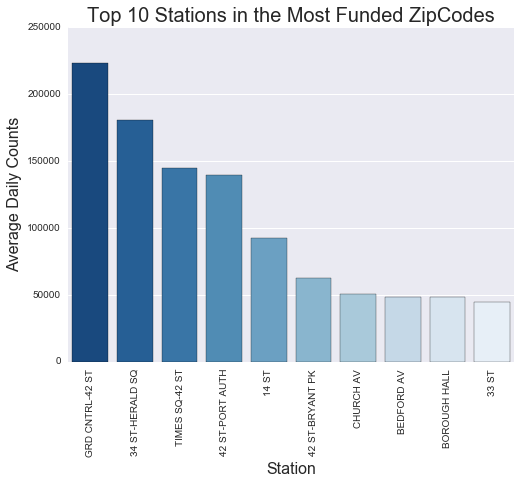

In [226]:
fig1 = sns.barplot(data=df_top10_dayzip,x='STATION',y='COUNTS',palette='Blues_r')
fig1.axes.set_title("Top 10 Stations in the Most Funded ZipCodes",fontsize=20)
fig1.set_xlabel('Station',fontsize=16)
fig1.set_ylabel('Average Daily Counts',fontsize=16)
plt.rcParams['figure.figsize']=(8,6)
for item in fig1.get_xticklabels():
    item.set_rotation(90)

In [322]:
data_april.head()

,C/A,UNIT,SCP,STATION,LINENAME,DATE,TIME,ENTRIES,EXITS,DATE_TIME,DAY_OF_WEEK,ZIPCODE
37,A002,R051,02-00-00,59 ST,NQR456,2016-04-01,00:00:00,5599639,1896005,2016-04-01 00:00:00,Friday,11209
38,A002,R051,02-00-00,59 ST,NQR456,2016-04-01,04:00:00,5599650,1896015,2016-04-01 04:00:00,Friday,11209
39,A002,R051,02-00-00,59 ST,NQR456,2016-04-01,08:00:00,5599690,1896110,2016-04-01 08:00:00,Friday,11209
40,A002,R051,02-00-00,59 ST,NQR456,2016-04-01,12:00:00,5599694,1896111,2016-04-01 12:00:00,Friday,11209
41,A002,R051,02-00-00,59 ST,NQR456,2016-04-01,16:00:00,5599946,1896170,2016-04-01 16:00:00,Friday,11209


## Quick Data Retrieval For Presentation

In [84]:
x = data_april[data_april['STATION'] == 'GRD CNTRL-42 ST']
y = x[x['DATE'] ==  datetime.date(2016,4,6)]
z = y[y['SCP'] == '00-00-08']
z.iloc[1:4]
# set(x[x['DATE'] ==  datetime.date(2016,4,6)]['SCP'])

,C/A,UNIT,SCP,STATION,LINENAME,DATE,TIME,ENTRIES,EXITS,DATE_TIME,DAY_OF_WEEK,ZIPCODE
148882,R238,R046,00-00-08,GRD CNTRL-42 ST,4567S,2016-04-06,04:00:00,43773605,9870803,2016-04-06 04:00:00,Wednesday,10011
148883,R238,R046,00-00-08,GRD CNTRL-42 ST,4567S,2016-04-06,08:00:00,43773605,9871234,2016-04-06 08:00:00,Wednesday,10011
148884,R238,R046,00-00-08,GRD CNTRL-42 ST,4567S,2016-04-06,12:00:00,3070,622,2016-04-06 12:00:00,Wednesday,10011


In [34]:
entry_unedit = data_april.groupby(by=['STATION','C/A','UNIT','SCP','DATE'])['ENTRIES'].apply(lambda x: max(x) - min(x))
exit_unedit = data_april.groupby(by=['STATION','C/A','UNIT','SCP','DATE'])['EXITS'].apply(lambda x: max(x) - min(x))

In [58]:
april_entries_unformatted = april_entries_raw.groupby(level=['STATION','DATE']).sum()
april_exits_unformatted = april_exits_raw.groupby(level=['STATION','DATE']).sum()

In [329]:
z = april_entries_unformatted['GRD CNTRL-42 ST']
# z.to_frame().reset_index().head(n=10)

## Calculate Counts for Each Day of the Week

In [421]:
june_weekday_entry_raw = data_june.groupby(by=['STATION','C/A','UNIT','SCP','DAY_OF_WEEK','DATE'],sort=False)['ENTRIES'].apply(lambda x: max(x) - min(x))
june_weekday_exits_raw = data_june.groupby(by=['STATION','C/A','UNIT','SCP','DAY_OF_WEEK','DATE'],sort=False)['EXITS'].apply(lambda x: max(x) - min(x))

In [422]:
june_weekday_entry = june_weekday_entry_raw.groupby(level=['UNIT','SCP']).apply(replace)
june_weekday_exits = june_weekday_exits_raw.groupby(level=['UNIT','SCP']).apply(replace)
june_weekday_total = june_weekday_entry + june_weekday_exits

In [423]:
june_weekday_mean = june_weekday_total.groupby(level=['STATION','DAY_OF_WEEK']).mean()

In [424]:
june_weekday_mean['GRD CNTRL-42 ST']

DAY_OF_WEEK
Friday       4450.172131
Monday       4564.389344
Saturday     1627.516393
Sunday       1369.815574
Thursday     4765.960656
Tuesday      4778.385246
Wednesday    4855.151316
dtype: float64

In [425]:
# Import Relevant Libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

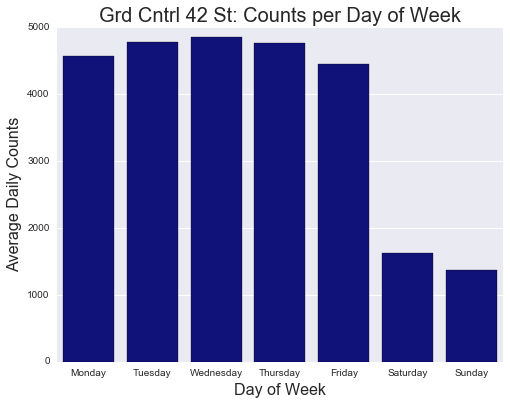

In [432]:
temp = june_weekday_mean['GRD CNTRL-42 ST'].to_frame()
temp.reset_index(inplace=True)
temp.columns = ['Day of Week','Average Counts']
temp['Day Numbers'] = [4, 0, 5, 6, 3, 1, 2]
temp.sort_values(by='Day Numbers', inplace=True)
temp
fig2 = sns.barplot(data=temp, x='Day of Week',y='Average Counts',color='darkblue')
fig2.axes.set_title("Grd Cntrl 42 St: Counts per Day of Week",fontsize=20)
fig2.set_xlabel('Day of Week',fontsize=16)
fig2.set_ylabel('Average Daily Counts',fontsize=16)
plt.rcParams['figure.figsize']=(8,6)

## For Blog

In [326]:
df_topstations = df_all[(df_all['STATION'] == 'GRD CNTRL-42 ST') |\
                  (df_all['STATION'] == '34 ST-HERALD SQ') |\
                  (df_all['STATION'] == 'TIMES SQ-42 ST') |\
                  (df_all['STATION'] == '42 ST-PORT AUTH') |\
                  (df_all['STATION'] == '14 ST')]

In [376]:
stn_inzip_alldays = entries_zip_dailytot + exits_zip_dailytot

In [375]:
df_inzip_alldays = stn_inzip_alldays.to_frame()
df_inzip_alldays.columns = ['Total Counts']
temp_a = df_inzip_alldays.loc[['GRD CNTRL-42 ST', '34 ST-HERALD SQ','TIMES SQ-42 ST','42 ST-PORT AUTH','14 ST']]

In [412]:
grdcentral_june = temp_a.loc['GRD CNTRL-42 ST'].iloc[-30:].reset_index()
heraldsq_june = temp_a.loc['34 ST-HERALD SQ'].iloc[-30:].reset_index()
timessq_june = temp_a.loc['TIMES SQ-42 ST'].iloc[-30:].reset_index()
portauth_june = temp_a.loc['42 ST-PORT AUTH'].iloc[-30:].reset_index()
fourteen_june = temp_a.loc['14 ST'].iloc[-30:].reset_index()

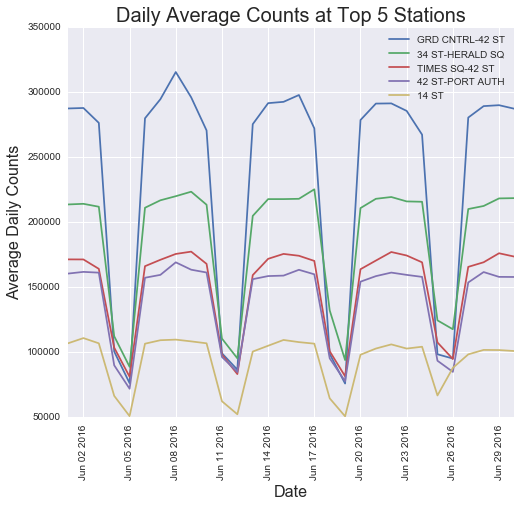

In [420]:
plt.plot(grdcentral_june['DATE'],grdcentral_june['Total Counts'],label='GRD CNTRL-42 ST');
plt.plot(heraldsq_june['DATE'],heraldsq_june['Total Counts'],label='34 ST-HERALD SQ');
plt.plot(timessq_june['DATE'],timessq_june['Total Counts'],label='TIMES SQ-42 ST');
plt.plot(portauth_june['DATE'],portauth_june['Total Counts'],label='42 ST-PORT AUTH');
plt.plot(fourteen_june['DATE'],fourteen_june['Total Counts'],label='14 ST');
plt.plot()
plt.rcParams['figure.figsize']=(8,7);
plt.xlabel('Date',fontsize=16);
plt.ylabel('Average Daily Counts',fontsize=16);
plt.title("Daily Average Counts at Top 5 Stations",fontsize=20);
plt.xticks(rotation='vertical');
plt.legend();

# Run This in Every New Session

In [3]:
# Read Stored Dataframe 
data_april = pd.read_pickle('data_april.pkl')
data_may = pd.read_pickle('data_may.pkl')
data_june = pd.read_pickle('data_june.pkl')

# Store Dataframes if Necessary

In [ ]:
# Store Dataframe 
data_april.to_pickle('data_april.pkl')
data_may.to_pickle('data_may.pkl')
data_june.to_pickle('data_june.pkl')